# Station S3 analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, places, viz_tools, visualisations
import xarray as xr
import pandas as pd
import pickle
import os
import bloomdrivers
import seaborn as sns
import cmocean


%matplotlib inline

### To recreate this notebook at a different location, follow these instructions: 

In [2]:
# The path to the directory where the pickle files are stored:
savedir='/ocean/aisabell/MEOPAR/extracted_files'
# Change 'S3' to the location of interest
loc='S3'
# What is the start year and end year+1 of the time range of interest?
startyear=2007
endyear=2021 # does NOT include this value
# Note: What is the model run?

# Note: non-location specific variables only need to be done for each year, not for each location
# Note: xticks in the plots will need to be changed
# Note: 201812 bloom timing variable load and plotting will also need to be removed

1.1363636363636362

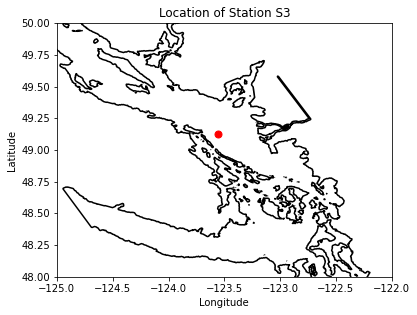

In [3]:
modver='201905'
# lat and lon information for place:
lon,lat=places.PLACES[loc]['lon lat']
# get place information on SalishSeaCast grid:
ij,ii=places.PLACES[loc]['NEMO grid ji']
jw,iw=places.PLACES[loc]['GEM2.5 grid ji']

fig, ax = plt.subplots(1,1,figsize = (6,6))
with xr.open_dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc') as mesh:
    ax.contour(mesh.nav_lon,mesh.nav_lat,mesh.tmask.isel(t=0,z=0),[0.1,],colors='k')
    tmask=np.array(mesh.tmask)
    gdept_1d=np.array(mesh.gdept_1d)
    e3t_0=np.array(mesh.e3t_0)
ax.plot(lon, lat, '.', markersize=14, color='red')
ax.set_ylim(48,50)
ax.set_xlim(-125,-122)
ax.set_title('Location of Station %s'%loc)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
viz_tools.set_aspect(ax,coords='map')

### Strait of Georgia Region:

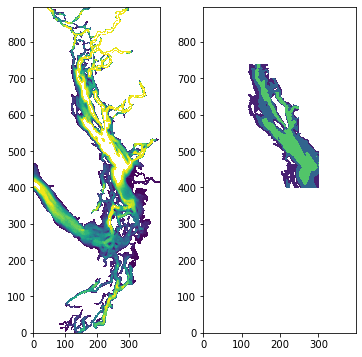

In [4]:
# define sog region:
fig, ax = plt.subplots(1,2,figsize = (6,6))
with xr.open_dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc') as bathy:
    bath=np.array(bathy.Bathymetry)
ax[0].contourf(bath,np.arange(0,250,10))
viz_tools.set_aspect(ax[0],coords='grid')
sogmask=np.copy(tmask[:,:,:,:])
sogmask[:,:,740:,:]=0
sogmask[:,:,700:,170:]=0
sogmask[:,:,550:,250:]=0
sogmask[:,:,:,302:]=0
sogmask[:,:,:400,:]=0
sogmask[:,:,:,:100]=0
#sogmask250[bath<250]=0
ax[1].contourf(np.ma.masked_where(sogmask[0,0,:,:]==0,bathy.Bathymetry),[0,100,250,550])

###  *** Stop and check, have you made pickle files for all the years? ***

In [5]:
# loop through years of spring time series (mid feb-june) for bloom timing for 201905 run
years=list()
bloomtime1=list()
bloomtime2=list()
bloomtime3=list()
for year in range(startyear,endyear):
    fname3=f'springBloomTime_{str(year)}_{loc}_{modver}.pkl'
    savepath3=os.path.join(savedir,fname3)
    bio_time0,sno30,sdiat0,sflag0,scili0,diat_alld0,no3_alld0,flag_alld0,cili_alld0,phyto_alld0,\
                 intdiat0,intphyto0,fracdiat0,sphyto0,percdiat0=pickle.load(open(savepath3,'rb'))
    # put code that calculates bloom timing here
    bt1=bloomdrivers.metric1_bloomtime(phyto_alld0,no3_alld0,bio_time0)
    bt2=bloomdrivers.metric2_bloomtime(sphyto0,sno30,bio_time0)
    bt3=bloomdrivers.metric3_bloomtime(sphyto0,sno30,bio_time0)
    years.append(year)
    bloomtime1.append(bt1)
    bloomtime2.append(bt2)
    bloomtime3.append(bt3)   
years=np.array(years)
bloomtime1=np.array(bloomtime1)
bloomtime2=np.array(bloomtime2)
bloomtime3=np.array(bloomtime3)

# get year day
yearday1=et.datetimeToYD(bloomtime1)  # convert to year day tool
yearday2=et.datetimeToYD(bloomtime2)
yearday3=et.datetimeToYD(bloomtime3)

### Combine separate year files into arrays:

In [6]:
# loop through years (for location specific drivers)

years=list()
windjan=list()
windfeb=list()
windmar=list()
solarjan=list()
solarfeb=list()
solarmar=list()
parjan=list()
parfeb=list()
parmar=list()
tempjan=list()
tempfeb=list()
tempmar=list()
saljan=list()
salfeb=list()
salmar=list()
zoojan=list()
zoofeb=list()
zoomar=list()
mesozoojan=list()
mesozoofeb=list()
mesozoomar=list()
microzoojan=list()
microzoofeb=list()
microzoomar=list()
intzoojan=list()
intzoofeb=list()
intzoomar=list()
intmesozoojan=list()
intmesozoofeb=list()
intmesozoomar=list()
intmicrozoojan=list()
intmicrozoofeb=list()
intmicrozoomar=list()
midno3jan=list()
midno3feb=list()
midno3mar=list()

for year in range(startyear,endyear):
    fname=f'JanToMarch_TimeSeries_{year}_{loc}_{modver}.pkl'
    savepath=os.path.join(savedir,fname)
    bio_time,diat_alld,no3_alld,flag_alld,cili_alld,microzoo_alld,mesozoo_alld,\
            intdiat,intphyto,spar,intmesoz,intmicroz,grid_time,temp,salinity,u_wind,v_wind,twind,\
            solar,no3_30to90m,sno3,sdiat,sflag,scili,intzoop,fracdiat,zoop_alld,sphyto,phyto_alld,\
            percdiat,wspeed,winddirec=pickle.load(open(savepath,'rb'))
    # put code that calculates drivers here
    wind=bloomdrivers.janfebmar_wspeed3(twind,wspeed)
    solar=bloomdrivers.janfebmar_irradiance(twind,solar)
    par=bloomdrivers.janfebmar_spar(bio_time,spar)
    temp=bloomdrivers.janfebmar_temp(grid_time,temp)
    sal=bloomdrivers.janfebmar_temp(grid_time,salinity)
    zoo=bloomdrivers.janfebmar_zooplankton(bio_time,zoop_alld)
    mesozoo=bloomdrivers.janfebmar_mesozooplankton(bio_time,mesozoo_alld)
    microzoo=bloomdrivers.janfebmar_microzooplankton(bio_time,microzoo_alld)
    intzoo=bloomdrivers.janfebmar_depth_intzoop(bio_time,intzoop)
    intmesozoo=bloomdrivers.janfebmar_depth_intmesozoop(bio_time,intmesoz)
    intmicrozoo=bloomdrivers.janfebmar_depth_intmicrozoop(bio_time,intmicroz)
    midno3=bloomdrivers.janfebmar_mid_depth_no3(bio_time,no3_30to90m)
    
    years.append(year)
    windjan.append(wind[0])
    windfeb.append(wind[1])
    windmar.append(wind[2])   
    solarjan.append(solar[0])
    solarfeb.append(solar[1])
    solarmar.append(solar[2])
    parjan.append(par[0])
    parfeb.append(par[1])
    parmar.append(par[2])
    tempjan.append(temp[0])
    tempfeb.append(temp[1])
    tempmar.append(temp[2])
    saljan.append(sal[0])
    salfeb.append(sal[1])
    salmar.append(sal[2])
    zoojan.append(zoo[0])
    zoofeb.append(zoo[1])
    zoomar.append(zoo[2])
    mesozoojan.append(mesozoo[0])
    mesozoofeb.append(mesozoo[1])
    mesozoomar.append(mesozoo[2])
    microzoojan.append(microzoo[0])
    microzoofeb.append(microzoo[1])
    microzoomar.append(microzoo[2])
    intzoojan.append(intzoo[0])
    intzoofeb.append(intzoo[1])
    intzoomar.append(intzoo[2])
    intmesozoojan.append(intmesozoo[0])
    intmesozoofeb.append(intmesozoo[1])
    intmesozoomar.append(intmesozoo[2])
    intmicrozoojan.append(intmicrozoo[0])
    intmicrozoofeb.append(intmicrozoo[1])
    intmicrozoomar.append(intmicrozoo[2])
    midno3jan.append(midno3[0])
    midno3feb.append(midno3[1])
    midno3mar.append(midno3[2])

years=np.array(years)
windjan=np.array(windjan)
windfeb=np.array(windfeb)
windmar=np.array(windmar)
solarjan=np.array(solarjan)
solarfeb=np.array(solarfeb)
solarmar=np.array(solarmar)
parjan=np.array(parjan)
parfeb=np.array(parfeb)
parmar=np.array(parmar)
tempjan=np.array(tempjan)
tempfeb=np.array(tempfeb)
tempmar=np.array(tempmar)
saljan=np.array(saljan)
salfeb=np.array(salfeb)
salmar=np.array(salmar)
zoojan=np.array(zoojan)
zoofeb=np.array(zoofeb)
zoomar=np.array(zoomar)
mesozoojan=np.array(mesozoojan)
mesozoofeb=np.array(mesozoofeb)
mesozoomar=np.array(mesozoomar)
microzoojan=np.array(microzoojan)
microzoofeb=np.array(microzoofeb)
microzoomar=np.array(microzoomar)
intzoojan=np.array(intzoojan)
intzoofeb=np.array(intzoofeb)
intzoomar=np.array(intzoomar)
intmesozoojan=np.array(intmesozoojan)
intmesozoofeb=np.array(intmesozoofeb)
intmesozoomar=np.array(intmesozoomar)
intmicrozoojan=np.array(intmicrozoojan)
intmicrozoofeb=np.array(intmicrozoofeb)
intmicrozoomar=np.array(intmicrozoomar)
midno3jan=np.array(midno3jan)
midno3feb=np.array(midno3feb)
midno3mar=np.array(midno3mar)

In [7]:
# loop through years (for non-location specific drivers)
fraserjan=list()
fraserfeb=list()
frasermar=list()
deepno3jan=list()
deepno3feb=list()
deepno3mar=list()

for year in range(startyear,endyear):
    fname2=f'JanToMarch_TimeSeries_{year}_{modver}.pkl'
    savepath2=os.path.join(savedir,fname2)
    no3_past250m,riv_time,rivFlow=pickle.load(open(savepath2,'rb'))
    # Code that calculates drivers here
    fraser=bloomdrivers.janfebmar_fraserflow(riv_time,rivFlow)
    fraserjan.append(fraser[0])
    fraserfeb.append(fraser[1])
    frasermar.append(fraser[2])

    fname=f'JanToMarch_TimeSeries_{year}_{loc}_{modver}.pkl'
    savepath=os.path.join(savedir,fname)
    bio_time,diat_alld,no3_alld,flag_alld,cili_alld,microzoo_alld,mesozoo_alld,\
            intdiat,intphyto,spar,intmesoz,intmicroz,grid_time,temp,salinity,u_wind,v_wind,twind,\
            solar,no3_30to90m,sno3,sdiat,sflag,scili,intzoop,fracdiat,zoop_alld,sphyto,phyto_alld,\
            percdiat,wspeed,winddirec=pickle.load(open(savepath,'rb'))
    deepno3=bloomdrivers.janfebmar_deepno3(bio_time,no3_past250m)
 
    deepno3jan.append(deepno3[0])
    deepno3feb.append(deepno3[1])
    deepno3mar.append(deepno3[2])

fraserjan=np.array(fraserjan)
fraserfeb=np.array(fraserfeb)
frasermar=np.array(frasermar)
deepno3jan=np.array(deepno3jan)
deepno3feb=np.array(deepno3feb)
deepno3mar=np.array(deepno3mar)

In [8]:
# loop through years (for mixing drivers)

halojan=list()
halofeb=list()
halomar=list()

for year in range(startyear,endyear):
    fname4=f'JanToMarch_Mixing_{year}_{loc}_{modver}.pkl'
    savepath4=os.path.join(savedir,fname4)
    halocline,eddy,diss,depth=pickle.load(open(savepath4,'rb'))
    fname=f'JanToMarch_TimeSeries_{year}_{loc}_{modver}.pkl'
    savepath=os.path.join(savedir,fname)
    bio_time,diat_alld,no3_alld,flag_alld,cili_alld,microzoo_alld,mesozoo_alld,\
            intdiat,intphyto,spar,intmesoz,intmicroz,grid_time,temp,salinity,u_wind,v_wind,twind,\
            solar,no3_30to90m,sno3,sdiat,sflag,scili,intzoop,fracdiat,zoop_alld,sphyto,phyto_alld,\
            percdiat,wspeed,winddirec=pickle.load(open(savepath,'rb'))
    # put code that calculates drivers here
    halo=bloomdrivers.janfebmar_halocline(bio_time,halocline)
    halojan.append(halo[0])
    halofeb.append(halo[1])
    halomar.append(halo[2])

halojan=np.array(halojan)
halofeb=np.array(halofeb)
halomar=np.array(halomar)

In [9]:
# January dataframe
dfjan=pd.DataFrame({'metric1':yearday1, 'metric2':yearday2, 'metric3':yearday3, 'wind':windjan,'solar':solarjan,
                  'temp':tempjan,'sal':saljan,'midno3':midno3jan,'fraser':fraserjan,'deepno3':deepno3jan,'halocine':halojan})
# February dataframe
dffeb=pd.DataFrame({'metric1':yearday1, 'metric2':yearday2, 'metric3':yearday3, 'wind':windfeb,'solar':solarfeb,
                  'temp':tempfeb,'sal':salfeb,'midno3':midno3feb,'fraser':fraserfeb,'deepno3':deepno3feb,'halocine':halofeb})
# March dataframe
dfmar=pd.DataFrame({'metric1':yearday1, 'metric2':yearday2, 'metric3':yearday3, 'wind':windmar,'solar':solarmar,
                  'temp':tempmar,'sal':salmar,'midno3':midno3mar,'fraser':frasermar,'deepno3':deepno3mar,'halocine':halomar})

In [10]:
dfjan.cov()

,metric1,metric2,metric3,wind,solar,temp,sal,midno3,fraser,deepno3,halocine
metric1,167.192308,137.846154,128.192308,23.129078,-12.446660,-3.737684,-2.507605,4.392353,-600.550070,6.741225,-13.428416
metric2,137.846154,179.494505,145.901099,281.294891,-4.938732,-4.977896,-0.353398,5.227610,-778.202736,7.644347,-1.983367
metric3,128.192308,145.901099,132.335165,166.893530,-8.356181,-4.223339,-1.419171,4.309779,-801.435591,7.227635,-4.460019
wind,23.129078,281.294891,166.893530,8094.426045,-458.025790,13.867379,40.699889,23.576396,-936.027025,14.378985,177.962411
solar,-12.446660,-4.938732,-8.356181,-458.025790,67.435320,-3.160387,-2.825547,-1.706040,-23.614641,-1.121300,-10.159804
temp,-3.737684,-4.977896,-4.223339,13.867379,-3.160387,0.487680,0.404520,-0.077289,44.577452,-0.310055,0.720811
sal,-2.507605,-0.353398,-1.419171,40.699889,-2.825547,0.404520,0.863035,0.104467,-18.401152,-0.248327,1.601088
midno3,4.392353,5.227610,4.309779,23.576396,-1.706040,-0.077289,0.104467,0.570821,-54.905988,0.519644,0.122078
fraser,-600.550070,-778.202736,-801.435591,-936.027025,-23.614641,44.577452,-18.401152,-54.905988,25704.091440,-43.359271,3.227778
deepno3,6.741225,7.644347,7.227635,14.378985,-1.121300,-0.310055,-0.248327,0.519644,-43.359271,0.880773,-0.338169


In [11]:
dffeb.cov()

,metric1,metric2,metric3,wind,solar,temp,sal,midno3,fraser,deepno3,halocine
metric1,167.192308,137.846154,128.192308,274.279459,-53.858452,-0.713898,-4.898713,3.904678,-939.299268,6.694636,-4.389741
metric2,137.846154,179.494505,145.901099,360.325660,-28.377121,-6.032933,-5.024165,4.232697,-2148.530053,7.522579,0.747593
metric3,128.192308,145.901099,132.335165,291.662420,-37.739568,-4.270886,-5.689764,3.862083,-1862.155986,7.144473,0.061211
wind,274.279459,360.325660,291.662420,2108.504590,-133.188560,-10.889928,15.694070,9.299857,-5281.416721,15.042285,53.214231
solar,-53.858452,-28.377121,-37.739568,-133.188560,58.542495,-0.877576,2.507346,-1.635060,240.859673,-3.642172,1.174798
temp,-0.713898,-6.032933,-4.270886,-10.889928,-0.877576,0.714746,0.317722,-0.152104,183.593070,-0.308140,-0.157110
sal,-4.898713,-5.024165,-5.689764,15.694070,2.507346,0.317722,1.535570,0.018919,-60.189150,-0.645027,1.301662
midno3,3.904678,4.232697,3.862083,9.299857,-1.635060,-0.152104,0.018919,0.473593,-161.052481,0.426217,-0.012849
fraser,-939.299268,-2148.530053,-1862.155986,-5281.416721,240.859673,183.593070,-60.189150,-161.052481,122323.912955,-76.481005,-134.642912
deepno3,6.694636,7.522579,7.144473,15.042285,-3.642172,-0.308140,-0.645027,0.426217,-76.481005,0.869508,-0.216816


In [12]:
dfmar.cov()

,metric1,metric2,metric3,wind,solar,temp,sal,midno3,fraser,deepno3,halocine
metric1,167.192308,137.846154,128.192308,683.907352,-182.929908,-2.243489,4.867424,5.951665,-850.715675,6.772832,12.937388
metric2,137.846154,179.494505,145.901099,754.719649,-181.010106,-6.634223,5.431145,7.012743,-3185.425422,7.515965,13.697898
metric3,128.192308,145.901099,132.335165,648.325174,-163.303261,-4.494384,4.504952,6.459397,-2129.210389,7.127748,11.296432
wind,683.907352,754.719649,648.325174,5149.923947,-1106.450749,-20.041112,33.947953,35.910364,-2988.681860,42.878490,135.845906
solar,-182.929908,-181.010106,-163.303261,-1106.450749,401.115077,2.802207,-6.910096,-5.339316,-1722.072976,-8.563671,-19.872191
temp,-2.243489,-6.634223,-4.494384,-20.041112,2.802207,0.460763,-0.076910,-0.322029,238.741716,-0.324212,-0.253645
sal,4.867424,5.431145,4.504952,33.947953,-6.910096,-0.076910,0.896922,0.248659,-169.872150,-0.129176,1.876504
midno3,5.951665,7.012743,6.459397,35.910364,-5.339316,-0.322029,0.248659,0.673588,-229.004563,0.527731,0.807674
fraser,-850.715675,-3185.425422,-2129.210389,-2988.681860,-1722.072976,238.741716,-169.872150,-229.004563,234451.617848,-54.719142,-126.928343
deepno3,6.772832,7.515965,7.127748,42.878490,-8.563671,-0.324212,-0.129176,0.527731,-54.719142,0.853843,0.670977


### Correlation matrix for January Values


<AxesSubplot:>

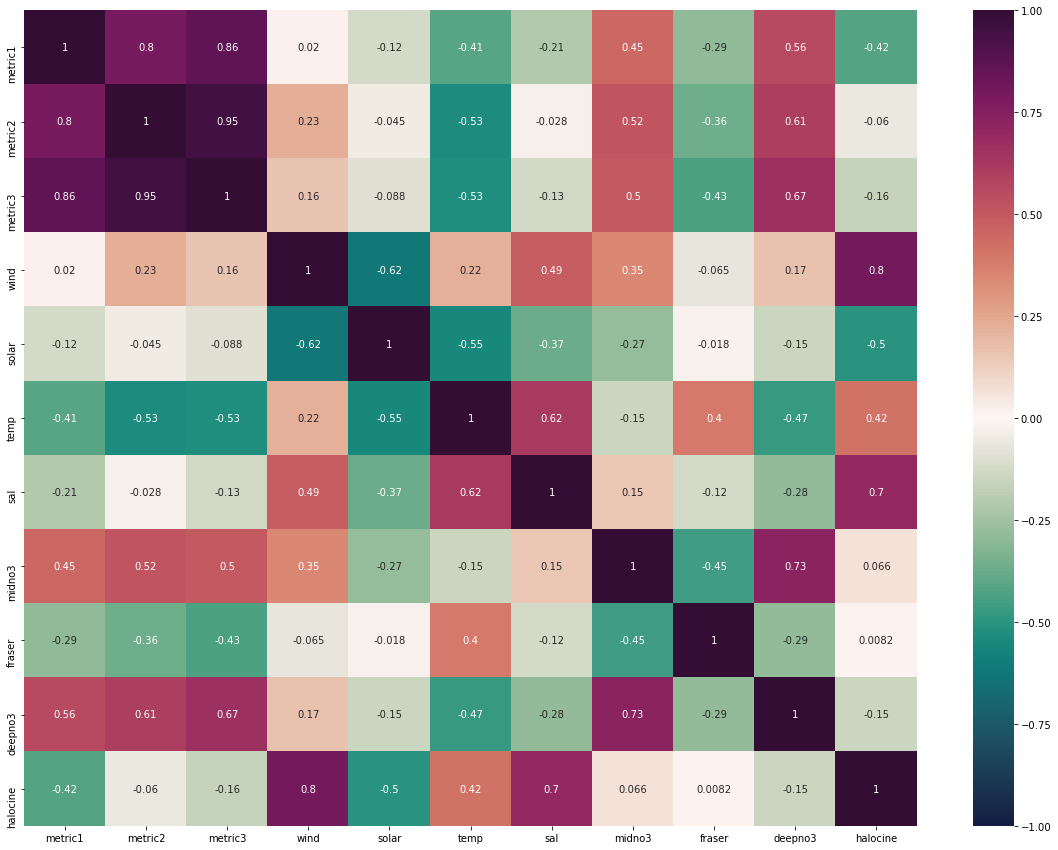

In [13]:
plt.subplots(figsize=(20,15))
cm1=cmocean.cm.curl
sns.heatmap(dfjan.corr(), annot = True,cmap=cm1,vmin=-1,vmax=1)

### Correlation matrix for February Values

<AxesSubplot:>

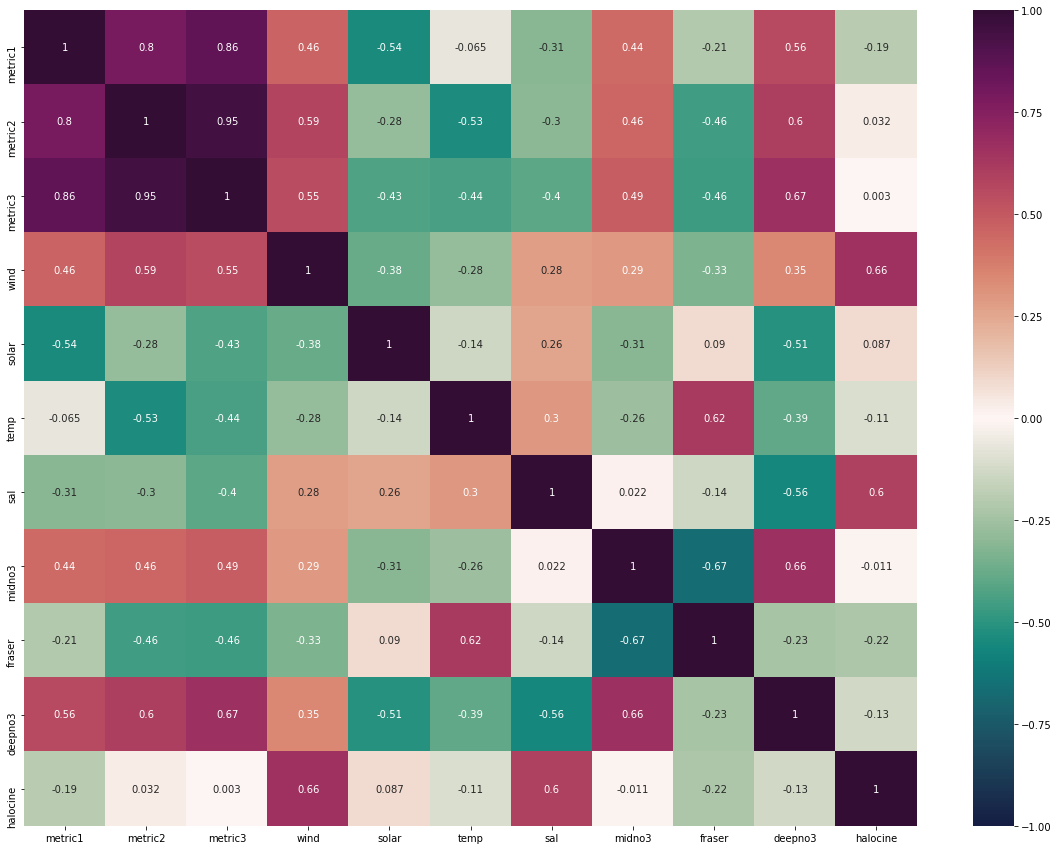

In [14]:
plt.subplots(figsize=(20,15))
cm1=cmocean.cm.curl
sns.heatmap(dffeb.corr(), annot = True,cmap=cm1,vmin=-1,vmax=1)

### Correlation matrix for March Values

<AxesSubplot:>

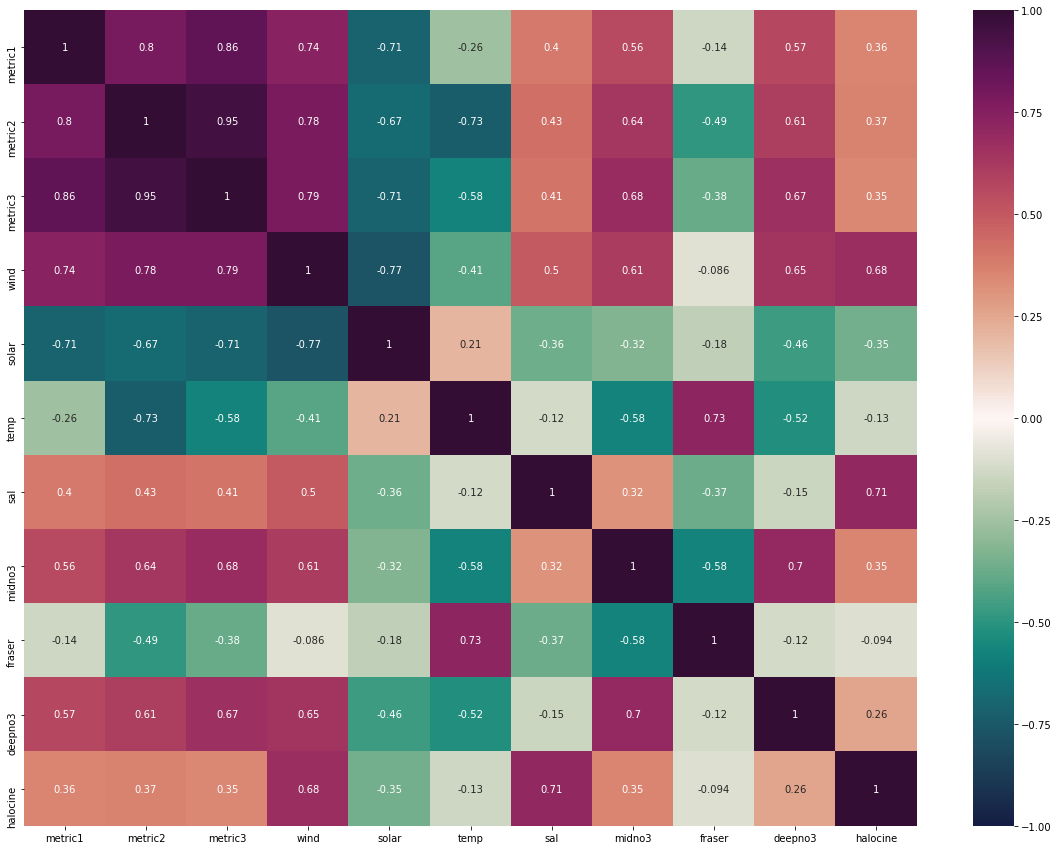

In [15]:
plt.subplots(figsize=(20,15))
cm1=cmocean.cm.curl
sns.heatmap(dfmar.corr(), annot = True,cmap=cm1,vmin=-1,vmax=1)

### Correlation plots of wind residuals

In [16]:
# Wind residual calculations for each metric
windresid1=list()
y,r2,m,b=bloomdrivers.reg_r2(windmar,yearday1)
for ind,y in enumerate(yearday1):
    x=windmar[ind]
    windresid1.append(y-(m*x+b))

windresid2=list()
y,r2,m,b=bloomdrivers.reg_r2(windmar,yearday2)
for ind,y in enumerate(yearday2):
    x=windmar[ind]
    windresid2.append(y-(m*x+b))
    
windresid3=list()
y,r2,m,b=bloomdrivers.reg_r2(windmar,yearday3)
for ind,y in enumerate(yearday3):
    x=windmar[ind]
    windresid3.append(y-(m*x+b))

In [17]:
dfwind=pd.DataFrame({'wind':windmar,'windresid1':windresid1,'windresid2':windresid2,'windresid3':windresid3,'solar':solarjan,
                  'temp':tempjan,'sal':saljan,'midno3':midno3jan,'fraser':fraserjan,'deepno3':deepno3jan,'halocine':halojan})

<AxesSubplot:>

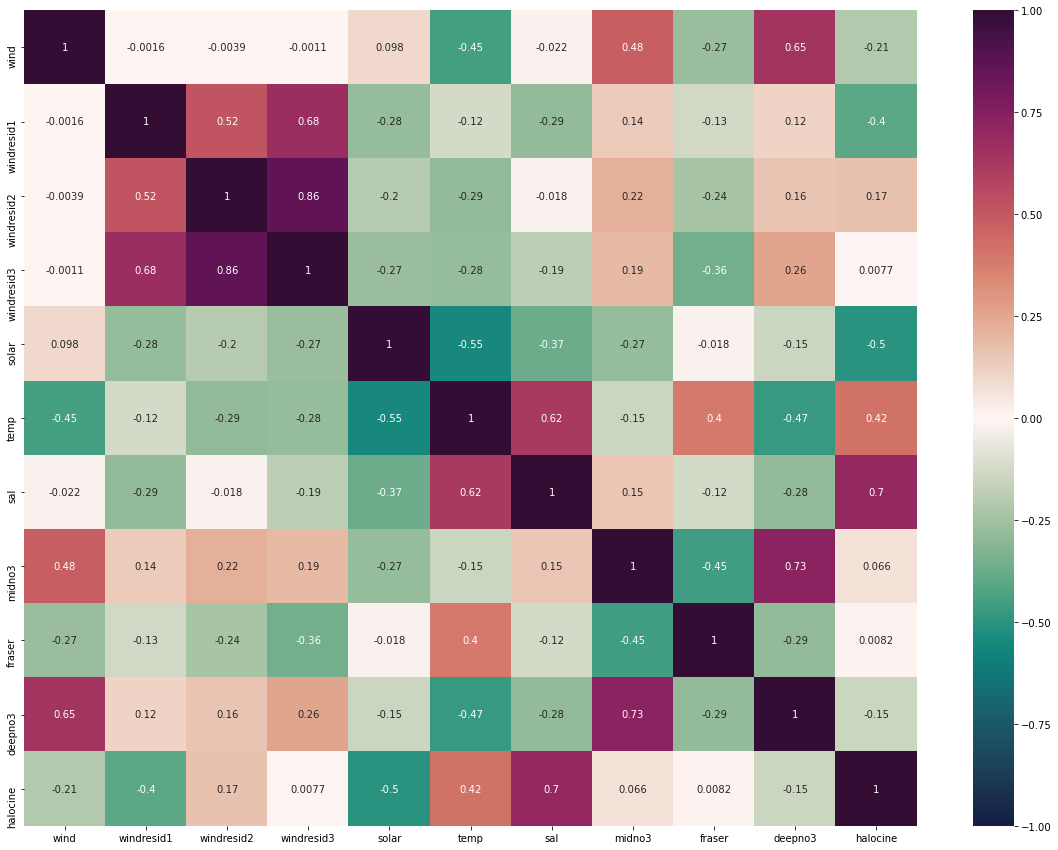

In [18]:
plt.subplots(figsize=(20,15))
cm1=cmocean.cm.curl
sns.heatmap(dfwind.corr(), annot = True,cmap=cm1,vmin=-1,vmax=1)

AttributeError: 'numpy.ndarray' object has no attribute 'transAxes'

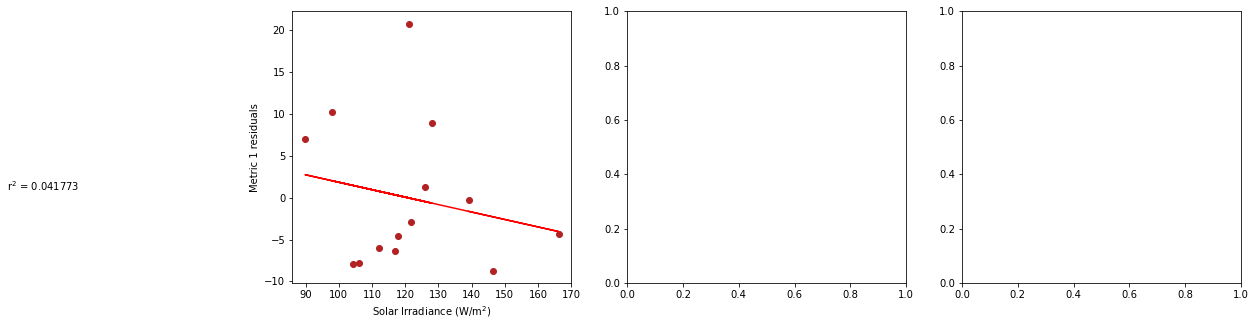

In [22]:
# ---------- Solar ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(solarmar,windresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,windresid1)
ax4[0].plot(solarmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[1].plot(solarmar,windresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Wind Residuals vs. March Average Solar Radiation')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,windresid2)
ax4[1].plot(solarmar, y, 'r')
ax4[1].text(0.6, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[1].text(0.6,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[2].plot(solarmar,windresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,windresid3)
ax4[2].plot(solarmar, y, 'r', label='Fitted Line')
ax4[2].text(1.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[2].text(1.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)
fig4.legend()

In [ ]:
# ---------- Temperature ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(tempmar,windresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,windresid1)
ax4[0].plot(tempmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[1].plot(tempmar,windresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Wind Residuals vs. March Average Surface Temperature')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,windresid2)
ax4[1].plot(tempmar, y, 'r')
ax4[1].text(0.6, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[1].text(0.6,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[2].plot(tempmar,windresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[2].set_ylabel('Metric 3  residuals')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,windresid3)
ax4[2].plot(tempmar, y, 'r', label='Fitted Line')
ax4[2].text(1.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[2].text(1.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)
fig4.legend()

In [ ]:
# ---------- Mid NO3 ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(midno3mar,windresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Concentration ($\mu$M N)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,windresid1)
ax4[0].plot(midno3mar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[1].plot(midno3mar,windresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Concentration ($\mu$M N)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Wind Residuals vs. March Average Mid Depth Nitrate (30-90m)')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,windresid2)
ax4[1].plot(midno3mar, y, 'r')
ax4[1].text(0.6, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[1].text(0.6,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[2].plot(midno3mar,windresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Concentration ($\mu$M N)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,windresid3)
ax4[2].plot(midno3mar, y, 'r', label='Fitted Line')
ax4[2].text(1.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[2].text(1.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)
fig4.legend()

In [ ]:
# ---------- Deep NO3 ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(deepno3mar,windresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Concentration ($\mu$M N)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,windresid1)
ax4[0].plot(deepno3mar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[1].plot(deepno3mar,windresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Concentration ($\mu$M N)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Wind Residuals vs. March Average Deep Nitrate (below 250m)')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,windresid2)
ax4[1].plot(deepno3mar, y, 'r')
ax4[1].text(0.6, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[1].text(0.6,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[2].plot(deepno3mar,windresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Concentration ($\mu$M N)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,windresid3)
ax4[2].plot(deepno3mar, y, 'r', label='Fitted Line')
ax4[2].text(1.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[2].text(1.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)
fig4.legend()

In [ ]:
# ---------- Salinity ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(salmar,windresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Salinity (g/kg)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(salmar,windresid1)
ax4[0].plot(salmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[1].plot(salmar,windresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Salinity (g/kg)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Wind Residuals vs. March Average Absolute Surface Salinity')
y,r2,m,b=bloomdrivers.reg_r2(salmar,windresid2)
ax4[1].plot(salmar, y, 'r')
ax4[1].text(0.6, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[1].text(0.6,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[2].plot(salmar,windresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Salinity (g/kg)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(salmar,windresid3)
ax4[2].plot(salmar, y, 'r', label='Fitted Line')
ax4[2].text(1.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[2].text(1.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)
fig4.legend()

In [ ]:
# ---------- Fraser ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(frasermar,windresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,windresid1)
ax4[0].plot(frasermar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[1].plot(frasermar,windresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Wind Residuals vs. March Average Fraser Flow')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,windresid2)
ax4[1].plot(frasermar, y, 'r')
ax4[1].text(0.6, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[1].text(0.6,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[2].plot(frasermar,windresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,windresid3)
ax4[2].plot(frasermar, y, 'r', label='Fitted Line')
ax4[2].text(1.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[2].text(1.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)
fig4.legend()

In [ ]:
# ---------- Halocline ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(halomar,windresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Halocline Depth (m)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(halomar,windresid1)
ax4[0].plot(halomar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[1].plot(halomar,windresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Halocline Depth (m)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Wind Residuals vs. March Halocline Depth')
y,r2,m,b=bloomdrivers.reg_r2(halomar,windresid2)
ax4[1].plot(halomar, y, 'r')
ax4[1].text(0.6, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[1].text(0.6,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[2].plot(halomar,windresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Halocline Depth (m)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(halomar,windresid3)
ax4[2].plot(halomar, y, 'r', label='Fitted Line')
ax4[2].text(1.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[2].text(1.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)
fig4.legend()

### Correlation plots of solar residuals

In [ ]:
#  residual calculations for each metric
solarresid1=list()
y,r2,m,b=bloomdrivers.reg_r2(solarmar,yearday1)
for ind,y in enumerate(yearday1):
    x=solarmar[ind]
    solarresid1.append(y-(m*x+b))

solarresid2=list()
y,r2,m,b=bloomdrivers.reg_r2(solarmar,yearday2)
for ind,y in enumerate(yearday2):
    x=solarmar[ind]
    solarresid2.append(y-(m*x+b))
    
solarresid3=list()
y,r2,m,b=bloomdrivers.reg_r2(solarmar,yearday3)
for ind,y in enumerate(yearday3):
    x=solarmar[ind]
    solarresid3.append(y-(m*x+b))

In [ ]:
dfsolar=pd.DataFrame({'solar':solarjan,'solarresid1':solarresid1,'solarresid2':solarresid2,'solarresid3':solarresid3,'wind':windmar,
                  'temp':tempjan,'sal':saljan,'midno3':midno3jan,'fraser':fraserjan,'deepno3':deepno3jan,'halocine':halojan})

In [ ]:
plt.subplots(figsize=(20,15))
cm1=cmocean.cm.curl
sns.heatmap(dfsolar.corr(), annot = True,cmap=cm1,vmin=-1,vmax=1)

In [ ]:
# ---------- wind ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(windmar,solarresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(windmar,solarresid1)
ax4[0].plot(windmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[1].plot(windmar,solarresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Solar Residuals vs. March Average Wind Speed Cubed')
y,r2,m,b=bloomdrivers.reg_r2(windmar,solarresid2)
ax4[1].plot(windmar, y, 'r')
ax4[1].text(0.6, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[1].text(0.6,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[2].plot(windmar,solarresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(windmar,solarresid3)
ax4[2].plot(windmar, y, 'r', label='Fitted Line')
ax4[2].text(1.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[2].text(1.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)
fig4.legend()

In [ ]:
# ---------- Temperature ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(tempmar,solarresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,solarresid1)
ax4[0].plot(tempmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[1].plot(tempmar,solarresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Solar Residuals vs. March Average Surface Temperature')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,solarresid2)
ax4[1].plot(tempmar, y, 'r')
ax4[1].text(0.6, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[1].text(0.6,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[2].plot(tempmar,solarresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,solarresid3)
ax4[2].plot(tempmar, y, 'r', label='Fitted Line')
ax4[2].text(1.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[2].text(1.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)
fig4.legend()

In [ ]:
# ---------- Mid NO3 ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(midno3mar,solarresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Concentration ($\mu$M N)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,solarresid1)
ax4[0].plot(midno3mar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[1].plot(midno3mar,solarresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Concentration ($\mu$M N)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Solar Residuals vs. March Average Mid Depth Nitrate (30-90m)')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,solarresid2)
ax4[1].plot(midno3mar, y, 'r')
ax4[1].text(0.6, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[1].text(0.6,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[2].plot(midno3mar,solarresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Concentration ($\mu$M N)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,solarresid3)
ax4[2].plot(midno3mar, y, 'r', label='Fitted Line')
ax4[2].text(1.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[2].text(1.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)
fig4.legend()

In [ ]:
# ---------- Deep NO3 ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(deepno3mar,solarresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Concentration ($\mu$M N)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,solarresid1)
ax4[0].plot(deepno3mar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[1].plot(deepno3mar,solarresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Concentration ($\mu$M N)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Solar Residuals vs. March Average Deep Nitrate (below 250m)')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,solarresid2)
ax4[1].plot(deepno3mar, y, 'r')
ax4[1].text(0.6, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[1].text(0.6,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[2].plot(deepno3mar,solarresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Concentration ($\mu$M N)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,solarresid3)
ax4[2].plot(deepno3mar, y, 'r', label='Fitted Line')
ax4[2].text(1.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[2].text(1.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)
fig4.legend()

In [ ]:
# ---------- Salinity ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(salmar,solarresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Salinity (g/kg)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(salmar,solarresid1)
ax4[0].plot(salmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[1].plot(salmar,solarresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Salinity (g/kg)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Solar Residuals vs. March Average Absolute Surface Salinity')
y,r2,m,b=bloomdrivers.reg_r2(salmar,solarresid2)
ax4[1].plot(salmar, y, 'r')
ax4[1].text(0.6, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[1].text(0.6,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[2].plot(salmar,solarresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Salinity (g/kg)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(salmar,solarresid3)
ax4[2].plot(salmar, y, 'r', label='Fitted Line')
ax4[2].text(1.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[2].text(1.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)
fig4.legend()

In [ ]:
# ---------- Fraser ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(frasermar,solarresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,solarresid1)
ax4[0].plot(frasermar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[1].plot(frasermar,solarresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Solar Residuals vs. March Average Fraser Flow')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,solarresid2)
ax4[1].plot(frasermar, y, 'r')
ax4[1].text(0.6, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[1].text(0.6,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[2].plot(frasermar,solarresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,solarresid3)
ax4[2].plot(frasermar, y, 'r', label='Fitted Line')
ax4[2].text(1.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[2].text(1.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)
fig4.legend()

In [ ]:
# ---------- Halocline ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(halomar,solarresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Halocline Depth (m)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(halomar,solarresid1)
ax4[0].plot(halomar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[1].plot(halomar,solarresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Halocline Depth (m)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Solar Residuals vs. March Halocline Depth')
y,r2,m,b=bloomdrivers.reg_r2(halomar,solarresid2)
ax4[1].plot(halomar, y, 'r')
ax4[1].text(0.6, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[1].text(0.6,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[2].plot(halomar,solarresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Halocline Depth (m)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(halomar,solarresid3)
ax4[2].plot(halomar, y, 'r', label='Fitted Line')
ax4[2].text(1.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[2].text(1.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)
fig4.legend()

### Correlation plots of temperature residuals

In [ ]:
#  residual calculations for each metric
tempresid1=list()
y,r2,m,b=bloomdrivers.reg_r2(tempmar,yearday1)
for ind,y in enumerate(yearday1):
    x=tempmar[ind]
    tempresid1.append(y-(m*x+b))

tempresid2=list()
y,r2,m,b=bloomdrivers.reg_r2(tempmar,yearday2)
for ind,y in enumerate(yearday2):
    x=tempmar[ind]
    tempresid2.append(y-(m*x+b))
    
tempresid3=list()
y,r2,m,b=bloomdrivers.reg_r2(tempmar,yearday3)
for ind,y in enumerate(yearday3):
    x=tempmar[ind]
    tempresid3.append(y-(m*x+b))

In [ ]:
dftemp=pd.DataFrame({'temp':tempjan,'tempresid1':tempresid1,'tempresid2':tempresid2,'tempresid3':tempresid3,'wind':windmar,'solar':solarjan,
                  'sal':saljan,'midno3':midno3jan,'fraser':fraserjan,'deepno3':deepno3jan,'halocine':halojan})

In [ ]:
plt.subplots(figsize=(20,15))
cm1=cmocean.cm.curl
sns.heatmap(dftemp.corr(), annot = True,cmap=cm1,vmin=-1,vmax=1)

In [ ]:
# ---------- wind ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(windmar,tempresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(windmar,tempresid1)
ax4[0].plot(windmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[1].plot(windmar,tempresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Temperature Residuals vs. March Average Wind Speed Cubed')
y,r2,m,b=bloomdrivers.reg_r2(windmar,tempresid2)
ax4[1].plot(windmar, y, 'r')
ax4[1].text(0.6, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[1].text(0.6,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[2].plot(windmar,tempresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(windmar,tempresid3)
ax4[2].plot(windmar, y, 'r', label='Fitted Line')
ax4[2].text(1.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[2].text(1.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)
fig4.legend()

In [ ]:
# ---------- Solar ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(solarmar,tempresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,tempresid1)
ax4[0].plot(solarmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[1].plot(solarmar,tempresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Temperature Residuals vs. March Average Solar Radiation')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,tempresid2)
ax4[1].plot(solarmar, y, 'r')
ax4[1].text(0.6, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[1].text(0.6,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[2].plot(solarmar,tempresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,tempresid3)
ax4[2].plot(solarmar, y, 'r', label='Fitted Line')
ax4[2].text(1.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[2].text(1.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)
fig4.legend()

In [ ]:
# ---------- Mid NO3 ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(midno3mar,tempresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Concentration ($\mu$M N)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,tempresid1)
ax4[0].plot(midno3mar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[1].plot(midno3mar,tempresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Concentration ($\mu$M N)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Temperature Residuals vs. March Average Mid Depth Nitrate (30-90m)')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,tempresid2)
ax4[1].plot(midno3mar, y, 'r')
ax4[1].text(0.6, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[1].text(0.6,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[2].plot(midno3mar,tempresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Concentration ($\mu$M N)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,tempresid3)
ax4[2].plot(midno3mar, y, 'r', label='Fitted Line')
ax4[2].text(1.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[2].text(1.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)
fig4.legend()

In [ ]:
# ---------- Deep NO3 ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(deepno3mar,tempresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Concentration ($\mu$M N)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,tempresid1)
ax4[0].plot(deepno3mar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[1].plot(deepno3mar,tempresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Concentration ($\mu$M N)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Temperature Residuals vs. March Average Deep Nitrate (below 250m)')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,tempresid2)
ax4[1].plot(deepno3mar, y, 'r')
ax4[1].text(0.6, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[1].text(0.6,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[2].plot(deepno3mar,tempresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Concentration ($\mu$M N)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,tempresid3)
ax4[2].plot(deepno3mar, y, 'r', label='Fitted Line')
ax4[2].text(1.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[2].text(1.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)
fig4.legend()

In [ ]:
# ---------- Salinity ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(salmar,tempresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Salinity (g/kg)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(salmar,tempresid1)
ax4[0].plot(salmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[1].plot(salmar,tempresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Salinity (g/kg)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Temperature Residuals vs. March Average Absolute Surface Salinity')
y,r2,m,b=bloomdrivers.reg_r2(salmar,tempresid2)
ax4[1].plot(salmar, y, 'r')
ax4[1].text(0.6, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[1].text(0.6,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[2].plot(salmar,tempresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Salinity (g/kg)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(salmar,tempresid3)
ax4[2].plot(salmar, y, 'r', label='Fitted Line')
ax4[2].text(1.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[2].text(1.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)
fig4.legend()

In [ ]:
# ---------- Fraser ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(frasermar,tempresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,tempresid1)
ax4[0].plot(frasermar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[1].plot(frasermar,tempresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Temperature Residuals vs. March Average Fraser Flow')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,tempresid2)
ax4[1].plot(frasermar, y, 'r')
ax4[1].text(0.6, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[1].text(0.6,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[2].plot(frasermar,tempresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,tempresid3)
ax4[2].plot(frasermar, y, 'r', label='Fitted Line')
ax4[2].text(1.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[2].text(1.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)
fig4.legend()

In [ ]:
# ---------- Halocline ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(halomar,tempresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Halocline Depth (m)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(halomar,tempresid1)
ax4[0].plot(halomar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[1].plot(halomar,tempresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Halocline Depth (m)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Temperature Residuals vs. March Halocline Depth')
y,r2,m,b=bloomdrivers.reg_r2(halomar,tempresid2)
ax4[1].plot(halomar, y, 'r')
ax4[1].text(0.6, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[1].text(0.6,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[2].plot(halomar,tempresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Halocline Depth (m)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(halomar,tempresid3)
ax4[2].plot(halomar, y, 'r', label='Fitted Line')
ax4[2].text(1.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[2].text(1.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)
fig4.legend()

### Correlation plots of mid NO3 residuals

In [ ]:
#  residual calculations for each metric
midno3resid1=list()
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,yearday1)
for ind,y in enumerate(yearday1):
    x=midno3mar[ind]
    midno3resid1.append(y-(m*x+b))

midno3resid2=list()
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,yearday2)
for ind,y in enumerate(yearday2):
    x=midno3mar[ind]
    midno3resid2.append(y-(m*x+b))
    
midno3resid3=list()
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,yearday3)
for ind,y in enumerate(yearday3):
    x=midno3mar[ind]
    midno3resid3.append(y-(m*x+b))

In [ ]:
dfmidno3=pd.DataFrame({'midno3':midno3jan,'midno3resid1':midno3resid1,'midno3resid2':midno3resid2,'midno3resid3':midno3resid3,'wind':windmar,'solar':solarjan,'temp':tempjan,
                  'sal':saljan,'fraser':fraserjan,'deepno3':deepno3jan,'halocine':halojan})

In [ ]:
plt.subplots(figsize=(20,15))
cm1=cmocean.cm.curl
sns.heatmap(dfmidno3.corr(), annot = True,cmap=cm1,vmin=-1,vmax=1)

In [ ]:
# ---------- wind ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(windmar,midno3resid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(windmar,midno3resid1)
ax4[0].plot(windmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[1].plot(windmar,midno3resid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Mid-depth Nitrate Residuals vs. March Average Wind Speed Cubed')
y,r2,m,b=bloomdrivers.reg_r2(windmar,midno3resid2)
ax4[1].plot(windmar, y, 'r')
ax4[1].text(0.6, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[1].text(0.6,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[2].plot(windmar,midno3resid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(windmar,midno3resid3)
ax4[2].plot(windmar, y, 'r', label='Fitted Line')
ax4[2].text(1.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[2].text(1.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)
fig4.legend()

In [ ]:
# ---------- Solar ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(solarmar,midno3resid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,midno3resid1)
ax4[0].plot(solarmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[1].plot(solarmar,midno3resid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Mid-depth Nitrate Residuals vs. March Average Solar Radiation')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,midno3resid2)
ax4[1].plot(solarmar, y, 'r')
ax4[1].text(0.6, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[1].text(0.6,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[2].plot(solarmar,midno3resid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,midno3resid3)
ax4[2].plot(solarmar, y, 'r', label='Fitted Line')
ax4[2].text(1.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[2].text(1.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)
fig4.legend()

In [ ]:
# ---------- Temperature ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(tempmar,midno3resid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,midno3resid1)
ax4[0].plot(tempmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[1].plot(tempmar,midno3resid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Mid-depth Nitrate Residuals vs. March Average Surface Temperature')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,midno3resid2)
ax4[1].plot(tempmar, y, 'r')
ax4[1].text(0.6, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[1].text(0.6,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[2].plot(tempmar,midno3resid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,midno3resid3)
ax4[2].plot(tempmar, y, 'r', label='Fitted Line')
ax4[2].text(1.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[2].text(1.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)
fig4.legend()

In [ ]:
# ---------- Deep NO3 ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(deepno3mar,midno3resid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Concentration ($\mu$M N)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,midno3resid1)
ax4[0].plot(deepno3mar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[1].plot(deepno3mar,midno3resid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Concentration ($\mu$M N)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Mid-depth Nitrate Residuals vs. March Average Deep Nitrate (below 250m)')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,midno3resid2)
ax4[1].plot(deepno3mar, y, 'r')
ax4[1].text(0.6, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[1].text(0.6,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[2].plot(deepno3mar,midno3resid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Concentration ($\mu$M N)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,midno3resid3)
ax4[2].plot(deepno3mar, y, 'r', label='Fitted Line')
ax4[2].text(1.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[2].text(1.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)
fig4.legend()

In [ ]:
# ---------- Salinity ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(salmar,midno3resid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Salinity (g/kg)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(salmar,midno3resid1)
ax4[0].plot(salmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[1].plot(salmar,midno3resid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Salinity (g/kg)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Mid-depth Nitrate Residuals vs. March Average Absolute Surface Salinity')
y,r2,m,b=bloomdrivers.reg_r2(salmar,midno3resid2)
ax4[1].plot(salmar, y, 'r')
ax4[1].text(0.6, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[1].text(0.6,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[2].plot(salmar,midno3resid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Salinity (g/kg)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(salmar,midno3resid3)
ax4[2].plot(salmar, y, 'r', label='Fitted Line')
ax4[2].text(1.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[2].text(1.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)
fig4.legend()

In [ ]:
# ---------- Fraser ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(frasermar,midno3resid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,midno3resid1)
ax4[0].plot(frasermar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[1].plot(frasermar,midno3resid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Mid-depth Nitrate Residuals vs. March Average Fraser Flow')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,midno3resid2)
ax4[1].plot(frasermar, y, 'r')
ax4[1].text(0.6, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[1].text(0.6,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[2].plot(frasermar,midno3resid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,midno3resid3)
ax4[2].plot(frasermar, y, 'r', label='Fitted Line')
ax4[2].text(1.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[2].text(1.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)
fig4.legend()

In [ ]:
# ---------- Halocline ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(halomar,midno3resid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Halocline Depth (m)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(halomar,midno3resid1)
ax4[0].plot(halomar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[1].plot(halomar,midno3resid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Halocline Depth (m)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Mid-depth Nitrate Residuals vs. March Halocline Depth')
y,r2,m,b=bloomdrivers.reg_r2(halomar,midno3resid2)
ax4[1].plot(halomar, y, 'r')
ax4[1].text(0.6, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[1].text(0.6,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)

ax4[2].plot(halomar,midno3resid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Halocline Depth (m)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(halomar,midno3resid3)
ax4[2].plot(halomar, y, 'r', label='Fitted Line')
ax4[2].text(1.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax.transAxes)
ax4[2].text(1.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax.transAxes)
fig4.legend()